# Isothermal decompression calculations

- In addition to crystallization and melting calculations, thermodynamic models are often used to investigate the processes of magma decompression.
- In this notebook we focus on the fluid composition during magma decompression by investigating different initial H2O contents.

**Before any calculations can be run** users need to download the alphaMELTS for Python files. Please see the installation guide on ReadTheDocs.

You will need to also download this excel spreadsheet:
https://github.com/gleesonm1/PetThermoTools/blob/master/docs/Examples/DecompressionTests/StHelens.xlsx




In [1]:
# import core python packages that we'll use for plotting and data manipulation.
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If the alphaMELTS for Python files have not been added to your Python path (see installation guide) then use the two lines below to add
# the location of the alphaMELTS files here.
import sys
sys.path.append(r'C:\Users\penny\Box\Berkeley_new\MELTS_Installation\alphamelts_py\alphamelts-py-2.3.1-win64')


import petthermotools as ptt 

ptt.__version__

'0.2.51'

To suppress outputs from the MELTS calculations run the cell below twice.

In [2]:
import platform
if platform.system() == "Darwin":
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

In this example we'll load melt inclusion compositions from the White Pumice of Mt St Helens published the study of Blundy and Cashman (2005).

In [3]:
# Melt inclusion and groundmass glass data from Mt St Helens (Blundy and Cashman, 2005)
StHelens = pd.read_excel('StHelens.xlsx', sheet_name='1980_WhitePumice')
StHelens = StHelens.fillna(0.0)
StHelens.head()

,sample,Type,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,H2O,Total
0,KCHB-4Aa,A1,68.05,0.33,12.96,2.72,0.12,0.98,1.95,5.60,1.93,4.63,99.26
1,KCHB-7Ab,A1,69.01,0.37,14.07,2.19,0.02,0.36,2.25,5.54,1.85,3.19,99.09
2,KCHB-8Aa,A1,70.19,0.35,14.70,2.52,0.03,0.34,2.24,6.51,1.72,1.83,100.43
3,KCHB-I IR,A1,65.81,0.51,15.03,2.13,0.00,0.37,2.35,5.65,2.44,4.92,99.2
4,KCHB-I IB',A1,69.71,0.21,14.15,2.48,0.00,0.45,2.23,6.39,2.03,2.66,100.29


For these simple decompression calculations we can simply pick any of the inclusions from the Blundy and Cashman (2005) study. Here we select a plagioclase-hosted melt incluion:

In [4]:
# select a representative composition of the Mt St Helens white pumice. Here we've chosen a more mafic (~65 wt% SiO2) water rich inclusion.
WhitePumice = StHelens.loc[23]
WhitePumice

sample    006-IOAO
Type            PI
SiO2         64.91
TiO2          0.41
Al2O3        13.31
FeOt          2.78
MnO           0.02
MgO           0.71
CaO           1.95
Na2O          5.49
K2O           1.99
H2O           6.38
Total        98.27
Name: 23, dtype: object

The inclusion has a measured H2O content of 6.38 wt%, but it is worth investigating how the degassing behaviour - and volatile composition - might change with different assumed initial CO2 contents. In the following cell we set up a decompression calculation using the measured H2O content and 4 different initial CO2 contents (in wt%).

In [46]:
# Lets run at 100, 500, 1000 and 2000 ppm CO2
Helens_decompress = ptt.isothermal_decompression(Model="MELTSv1.2.0", 
    bulk=WhitePumice, find_liquidus=True, fO2_buffer="FMQ", fO2_offset=2, 
    P_start_bar=3000, P_end_bar=50, dp_bar=20, fluid_sat = True,
    CO2_init = np.array([0.01, 0.05, 0.1, 0.2]),  Frac_fluid=False,
    Frac_solid=False,  label = 'CO2')

Completed 100.0 %


We can inspect the outputs and see that each run is now labeled by the initial CO2 content of that model.

In [47]:
Helens_decompress.keys()

dict_keys(['CO2 = 0.01 wt%', 'CO2 = 0.05 wt%', 'CO2 = 0.1 wt%', 'CO2 = 0.2 wt%'])

Examining the results from one model reveals the various Dictionaries and Pandas DataFrames that are created during the thermodynamic calculations.

In [48]:
Helens_decompress['CO2 = 0.01 wt%'].keys()

dict_keys(['Conditions', 'liquid1', 'liquid1_prop', 'fluid1', 'fluid1_prop', 'spinel1', 'spinel1_prop', 'plagioclase1', 'plagioclase1_prop', 'All', 'Mass', 'Volume', 'rho', 'Input'])

Specifically focusing on the fluid, we can use the cell below to examine the composition of the fluid phase for a single model.

In [49]:
Helens_decompress['CO2 = 0.05 wt%']['fluid1'].head()

,H2O_Fl,CO2_Fl,X_H2O_mol_Fl,X_CO2_mol_Fl
0,67.097841,32.902159,0.832915,0.167085
1,67.578631,32.421369,0.835936,0.164064
2,68.066036,31.933964,0.838976,0.161024
3,68.560116,31.439884,0.842035,0.157965
4,69.060924,30.939076,0.845115,0.154885


## Lets look at fluid composition vs. pressure and H2O and CO2 in the melt remaining

We can further examine the results by plotting up the fluid composition against pressure. In the cell below we can loop through the main results Dictionary to access each model in turn.

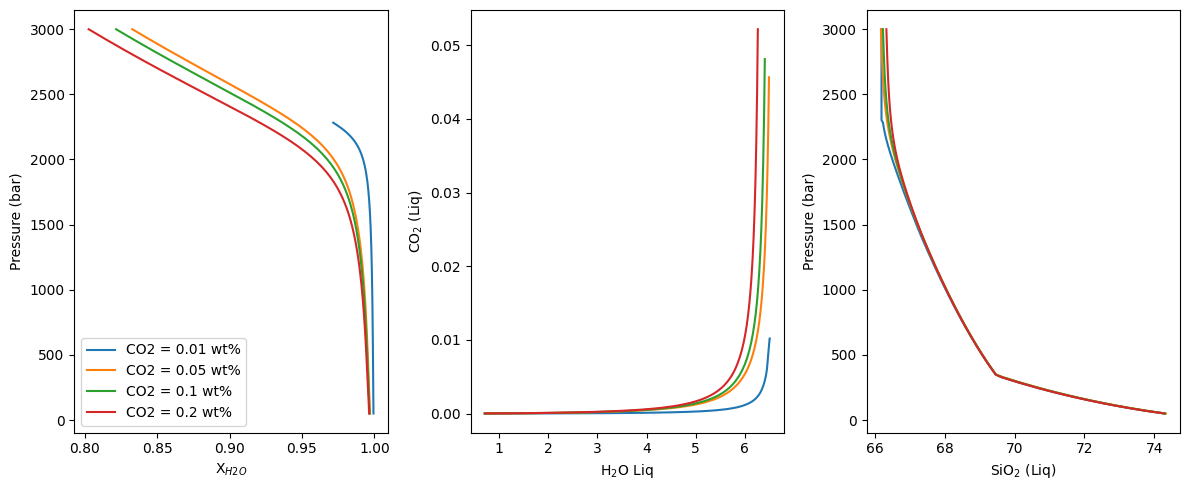

In [50]:
# set up figure layout
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 5))

# loop through main Dictionary
for key in Helens_decompress:
    # extract individial calculations
    res = Helens_decompress[key]

    # plot fluid chemistry vs pressure
    ax1.plot(res['All']['X_H2O_mol_Fl'],
        res['All']['P_bar'],'-',label=key)

    # plot melt CO2 vs pressure
    ax2.plot(res['All']['H2O_Liq'],
        res['All']['CO2_Liq'],'-',label=key)    

    # plot melt CO2 vs pressure
    ax3.plot(res['All']['SiO2_Liq'],
        res['All']['P_bar'],'-',label=key)  
a.legend(fontsize = 8)

ax1.set_xlabel('X$_{H2O}$')
ax1.set_ylabel('Pressure (bar)')

ax2.set_xlabel('H$_2$O Liq')
ax2.set_ylabel('CO$_2$ (Liq)')

ax3.set_ylabel('Pressure (bar)')
ax3.set_xlabel('SiO$_2$ (Liq)')

ax1.legend()
f.tight_layout()

## Why is SiO2 changing?

In [124]:
# Lets look at what phases are forming
Helens_decompress['CO2 = 0.05 wt%']['Mass']

,liquid1,fluid1,spinel1,plagioclase1
0,100.092448,0.000224,0.000000,0.000000
1,100.089016,0.003670,0.000000,0.000000
2,100.085493,0.007208,0.000000,0.000000
3,100.081873,0.010843,0.000000,0.000000
4,100.078150,0.014581,0.000000,0.000000
...,...,...,...,...
144,76.980622,5.632006,0.960657,16.548838
145,74.866057,5.735483,1.045814,18.476927
146,72.653640,5.841373,1.134242,20.497266
147,70.316118,5.951059,1.226900,22.634788


In [125]:
Helens_decompress['CO2 = 0.05 wt%']['Conditions']

,T_C,P_bar,h,s,v,mass,dvdp,logfO2
0,1001.1,3000.000000,-1.308251e+06,298.475850,46.281937,100.092672,-0.000428,-8.632511
1,1001.1,2980.067568,-1.308329e+06,298.487573,46.294026,100.092687,-0.000423,-8.634232
2,1001.1,2960.135135,-1.308407e+06,298.499305,46.306271,100.092701,-0.000418,-8.635953
3,1001.1,2940.202703,-1.308485e+06,298.511044,46.318684,100.092716,-0.000412,-8.637673
4,1001.1,2920.270270,-1.308562e+06,298.522794,46.331275,100.092731,-0.000406,-8.639394
...,...,...,...,...,...,...,...,...
144,1001.1,129.729730,-1.322264e+06,302.542429,291.764067,100.122123,0.209918,-8.880288
145,1001.1,109.797297,-1.322805e+06,302.639301,343.191343,100.124281,0.250704,-8.882009
146,1001.1,89.864865,-1.323365e+06,302.818971,417.689679,100.126520,0.309607,-8.883730
147,1001.1,69.932432,-1.323949e+06,303.126690,535.106526,100.128866,0.402208,-8.885450


## Lets plot what the phases are doing

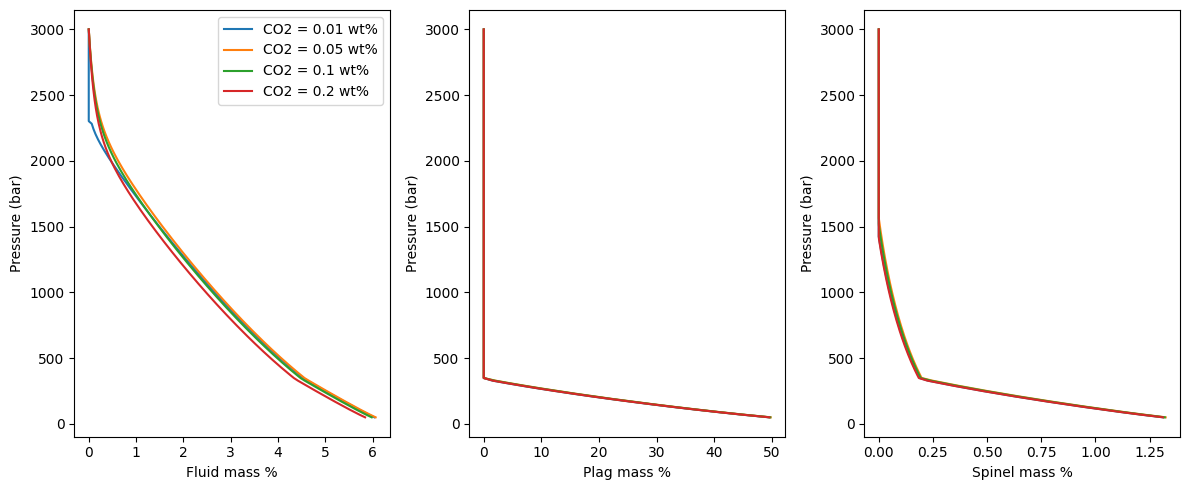

In [127]:
# set up figure layout
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 5))

# loop through main Dictionary
for key in Helens_decompress:
    # extract individial calculations
    res = Helens_decompress[key]

    # plot fluid chemistry vs pressure
    ax1.plot(100*res['All']['mass_Fl']/res['All']['mass'],
        res['All']['P_bar'],'-',label=key)

    # plot melt CO2 vs pressure
    ax2.plot(200*res['All']['mass_Plag']/res['All']['mass'],
        res['All']['P_bar'],'-',label=key)    

    # plot melt CO2 vs pressure
    ax3.plot(100*res['All']['mass_Sp']/res['All']['mass'],
        res['All']['P_bar'],'-',label=key)  

        
a.legend(fontsize = 8)

ax1.set_xlabel('Fluid mass %')
ax1.set_ylabel('Pressure (bar)')

ax2.set_xlabel('Plag mass %')
ax2.set_ylabel('Pressure (bar)')

ax3.set_xlabel('Spinel mass %')
ax3.set_ylabel('Pressure (bar)')

ax1.legend()
f.tight_layout()

## We can do the same for phase volume

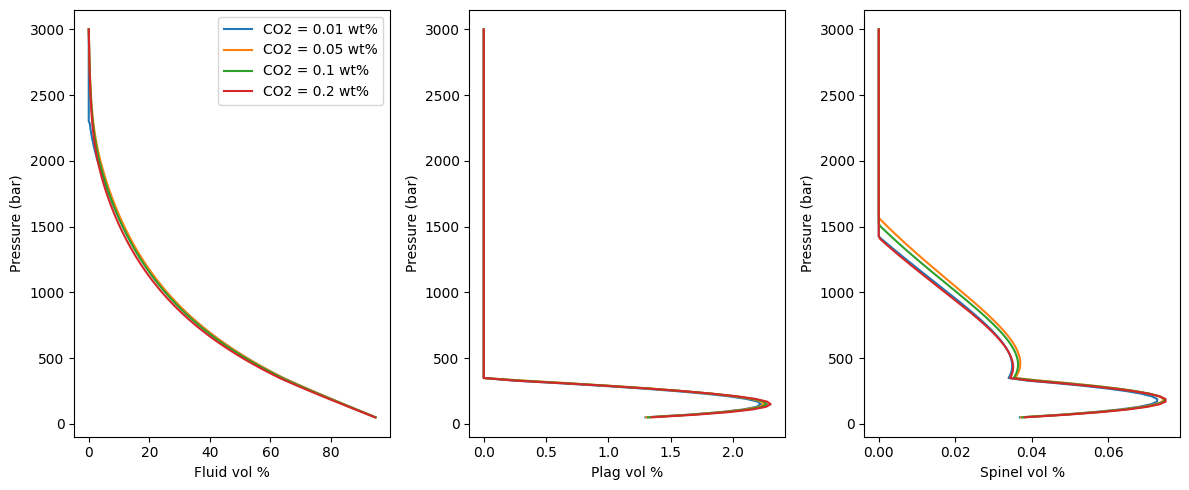

In [77]:
# set up figure layout
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 5))

# loop through main Dictionary
for key in Helens_decompress:
    # extract individial calculations
    res = Helens_decompress[key]

    # plot fluid chemistry vs pressure
    ax1.plot(100*res['All']['v_Fl']/res['All']['v'],
        res['All']['P_bar'],'-',label=key)

    # plot melt CO2 vs pressure
    ax2.plot(100*res['All']['v_Plag']/res['All']['v'],
        res['All']['P_bar'],'-',label=key)    

    # plot melt CO2 vs pressure
    ax3.plot(100*res['All']['v_Sp']/res['All']['v'],
        res['All']['P_bar'],'-',label=key)  
a.legend(fontsize = 8)

ax1.set_xlabel('Fluid vol %')
ax1.set_ylabel('Pressure (bar)')

ax2.set_xlabel('Plag vol %')
ax2.set_ylabel('Pressure (bar)')

ax3.set_xlabel('Spinel vol %')
ax3.set_ylabel('Pressure (bar)')

ax1.legend()
f.tight_layout()

## Lets think about what happens to liquid viscosity as we ascend
- We are going to use the python package Thermobar to do this

In [79]:
# ! pip install Thermobar

In [86]:
pt.__version__

'1.0.67'

In [91]:
# Example of how to calculate viscosity
import Thermobar as pt
Viscosity_500ppmCO2=pt.calculate_viscosity_giordano_2008(liq_comps=Helens_decompress['CO2 = 0.05 wt%']['liquid1'],
 T_K=Helens_decompress['CO2 = 0.05 wt%']['All']['T_C']+273.15,
H2O_Liq=Helens_decompress['CO2 = 0.05 wt%']['All']['H2O_Liq'])
Viscosity_500ppmCO2.head()

Water content from input overridden


,n_melt,logn_melt,T_K,A,B,C,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,...,b13,c1,c2,c3,c4,c5,c6,c11,T_K,logn_melt
0,268.402493,2.428787,1274.25,-4.55,8513.788562,54.297433,66.173518,0.417981,13.569088,0.0,...,805.248345,167.826553,120.482225,26.598682,20.036612,-76.164829,-302.810999,98.329190,1274.25,2.428787
1,268.763507,2.429370,1274.25,-4.55,8514.271070,54.330336,66.175787,0.417995,13.569554,0.0,...,805.363607,167.838563,120.490847,26.600586,20.038046,-76.170280,-302.783775,98.316349,1274.25,2.429370
2,269.139961,2.429978,1274.25,-4.55,8514.773486,54.364599,66.178116,0.418010,13.570031,0.0,...,805.483623,167.851069,120.499825,26.602568,20.039539,-76.175956,-302.755421,98.302976,1274.25,2.429978
3,269.532875,2.430612,1274.25,-4.55,8515.297083,54.400309,66.180510,0.418025,13.570522,0.0,...,805.608697,167.864100,120.509180,26.604633,20.041095,-76.181870,-302.725866,98.289037,1274.25,2.430612
4,269.943359,2.431273,1274.25,-4.55,8515.843232,54.437559,66.182972,0.418041,13.571027,0.0,...,805.739157,167.877691,120.518937,26.606787,20.042717,-76.188038,-302.695032,98.274496,1274.25,2.431273


Water content from input overridden
Water content from input overridden
Water content from input overridden
Water content from input overridden


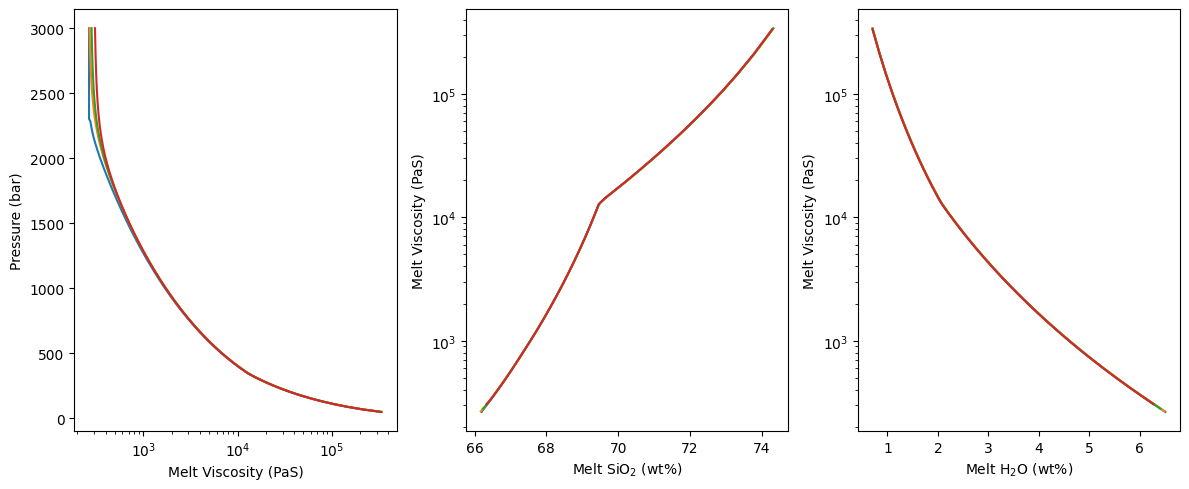

In [123]:
# set up figure layout
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 5))

# loop through main Dictionary
for key in Helens_decompress:
    # extract individial calculations
    res = Helens_decompress[key]['All']


    # Lets calculate viscosity now 
    Viscosity=pt.calculate_viscosity_giordano_2008(liq_comps=res,
    T_K=res['T_C']+273.15,
    H2O_Liq=res['H2O_Liq'])

    # plot fluid chemistry vs pressure
    ax1.plot(Viscosity['n_melt'],
        res['P_bar'],'-',label=key)

    ax2.plot(res['SiO2_Liq'], Viscosity['n_melt'], '-')

    ax3.plot(res['H2O_Liq'], Viscosity['n_melt'], '-')

ax1.set_xscale('log')
ax1.set_xlabel('Melt Viscosity (PaS)')
ax1.set_ylabel('Pressure (bar)')

ax2.set_yscale('log')
ax2.set_ylabel('Melt Viscosity (PaS)')
ax2.set_xlabel('Melt SiO$_2$ (wt%)')

ax3.set_yscale('log')
ax3.set_ylabel('Melt Viscosity (PaS)')
ax3.set_xlabel('Melt H$_2$O (wt%)')

fig.tight_layout()

## Lets plot the Plag compositions on a ternary diagram to compare to measured microlite chemistry

In [131]:
help(pt.plot_fspar_classification)

Help on function plot_fspar_classification in module Thermobar.mineral_equilibrium:

plot_fspar_classification(figsize=(6, 6), major_grid=False, minor_grid=False, labels=False, ticks=True, major_grid_kwargs={'ls': ':', 'lw': 0.5, 'c': 'k'}, minor_grid_kwargs={'ls': '-', 'lw': 0.25, 'c': 'lightgrey'}, fontsize_component_labels=10, fontsize_axes_labels=14, Anorthite_label='An', Anorthoclase_label='AnC', Albite_label='Ab', Oligoclase_label='Ol', Andesine_label='Ad', Labradorite_label='La', Bytownite_label='By', Sanidine_label='San')
    Plotting a feldspar ternary classification diagram according to Deer, Howie, and Zussman 1992 3rd edition.
    This function relies heavily on the python package python-ternary by Marc Harper et al. (2015).
    :cite:`harper2015`

    Inputs:
    figsize: tuple
    for figure size same as matplotlib

    major_grid: boolean,
    whether or not to show major grid lines shows lines every .2. Default = False

    minor_grid: boolean,
    whether or not to sho

c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
c:\Users\penny\anaconda3\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


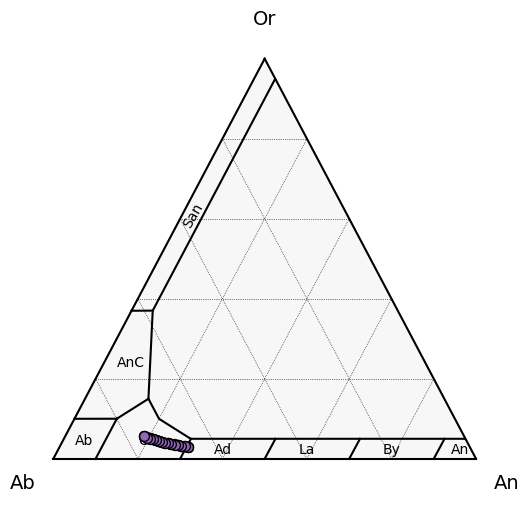

In [132]:
fig, tax = pt.plot_fspar_classification(figsize=(6, 6), major_grid=True, ticks=False, labels=True)


for key in Helens_decompress:
    # extract individial calculations
    plag = Helens_decompress[key]['plagioclase1']

    # calculate plag compositions
    tern_points=pt.tern_points_fspar(fspar_comps=Helens_decompress[key]['plagioclase1'])


    tax.scatter(
        tern_points,
        edgecolor="k",
        marker="o",
        s=50

    )
